# Extract Device Benchmarks

Extract benchmarks like Layer Fidelity (LF), Error per Layered Gate (EPLG), and 2Q errors. This notebook can be easily adjusted to extract any other type of device information.

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import re
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_gate_map
from scipy import stats

# Get backends

In [ ]:
# load service
service = QiskitRuntimeService()

In [155]:
# Specify a lits of backends
backend_names = ['ibm_fez', 'ibm_sherbrooke', 'ibm_brisbane', 'ibm_osaka']

In [156]:
# Get inidividual backends
backends = {}
for machine in backend_names:
    backend = service.backend(machine)
    backends[machine] = backend  

# Extract backend information

In [157]:
# Get Layer Fidelity (lf) data from backend properties
qchains = {}
lengths = {}
lfs = {}
eplgs = {}
for machine in backend_names:
    backend = backends[machine]
    # retrieve the best 100Q chain
    qchains[machine] = backend.properties().general_qlists[0]['qubits']
    # retrieve lf array
    length = []
    lf = []
    for prop in backend.properties().general:
        prop_dict = prop.to_dict()
        if 'lf' in prop_dict ['name']:
            l = int(re.findall(r'\d+', prop_dict ['name'])[0])
            length.append(l)
            lf.append(prop_dict ['value'])
    lfs[machine] = lf
    lengths[machine] = length
    num_2q_gates = [l - 1 for l in length]
    # calculate eplg array from lf
    eplg = [1 - (fid ** (1 / num_2q)) for num_2q, fid in zip(num_2q_gates, lf)]
    eplgs[machine] = eplg  

# Plot LF and EPLG data

In [221]:
# Define plot colors and markers
markers = ['o','s','v', 'p', '*', 'd', 'x']
colors =  ['blue', 'deeppink', 'green', 'red', 'gold', 'brown', 
          'steelblue', 'gray', 'lightgreen', 'darkmagenta', 'orange', 'lightskyblue', 'royalblue']

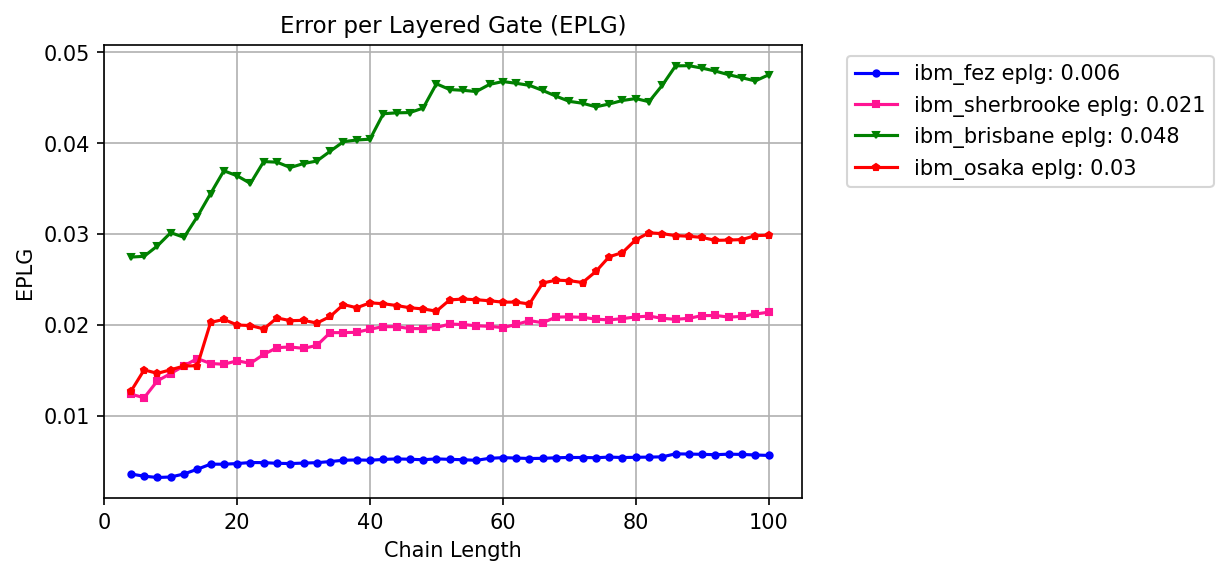

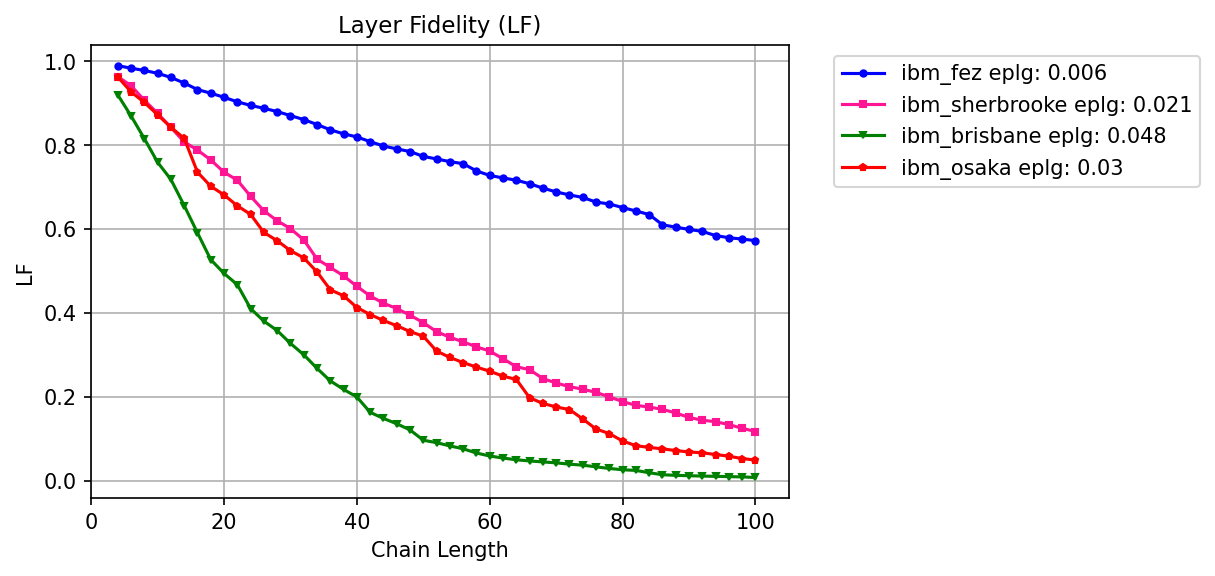

In [158]:
# Plot lf and eplg data per device
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
for i, machine in enumerate(backend_names):
    ax1.plot(lengths[machine], eplgs[machine], marker=markers[i % len(markers)], color=colors[i % len(colors)], markersize=3, linestyle="-", label= f'{machine} eplg: {round(eplgs[machine][-1],3)}')
    ax2.plot(lengths[machine], lfs[machine], marker=markers[i % len(markers)], color=colors[i % len(colors)], markersize=3, linestyle="-", label= f'{machine} eplg: {round(eplgs[machine][-1],3)}')

ax1.set_title(f"Error per Layered Gate (EPLG)", fontsize=11)
ax1.set_xlim(0, lengths[machine][-1] * 1.05)
ax1.set_ylabel("EPLG")
ax1.set_xlabel("Chain Length")
ax1.grid()
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.figure.set_dpi(150)
# fig1.savefig('eplg.png', dpi=150, bbox_inches='tight')

ax2.set_title(f"Layer Fidelity (LF)", fontsize=11)
ax2.set_xlim(0, lengths[machine][-1] * 1.05)
ax2.set_ylabel("LF")
ax2.set_xlabel("Chain Length")
ax2.grid()
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.figure.set_dpi(150)
# fig2.savefig('lf.png', dpi=150, bbox_inches='tight')

# Print and plot the best 100Q chain for each backend

In [159]:
# Print the best 100Q chain per backend
for machine in backend_names:
    print(f'Best 100Q chain for {machine}:')
    print(qchains[machine])

Best 100Q chain for ibm_fez:
[24, 23, 16, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 35, 34, 33, 39, 53, 54, 55, 59, 75, 74, 73, 79, 93, 92, 91, 90, 89, 88, 87, 86, 85, 77, 65, 66, 67, 68, 69, 70, 71, 58, 51, 50, 49, 48, 47, 46, 45, 44, 43, 56, 63, 62, 61, 76, 81, 82, 83, 96, 103, 102, 101, 116, 121, 122, 123, 124, 125, 117, 105, 106, 107, 108, 109, 110, 111, 112, 113, 119, 133, 132, 131, 130, 129, 128, 127, 137, 147, 146, 145, 144, 143, 142, 141]
Best 100Q chain for ibm_sherbrooke:
[68, 69, 70, 74, 89, 88, 87, 86, 85, 73, 66, 65, 64, 54, 45, 44, 43, 34, 24, 25, 26, 27, 28, 35, 47, 48, 49, 50, 51, 36, 32, 31, 30, 17, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82, 83, 92, 102, 101, 100, 99, 98, 91, 79, 78, 77, 76, 75, 90, 94, 95, 96, 109, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 112, 108, 107, 106, 105, 104, 111]
Best 100Q chain for ibm_brisbane:
[10, 11, 12, 17, 30, 31, 32, 36, 51, 50, 49, 48, 47, 35, 

100Q chain for ibm_osaka


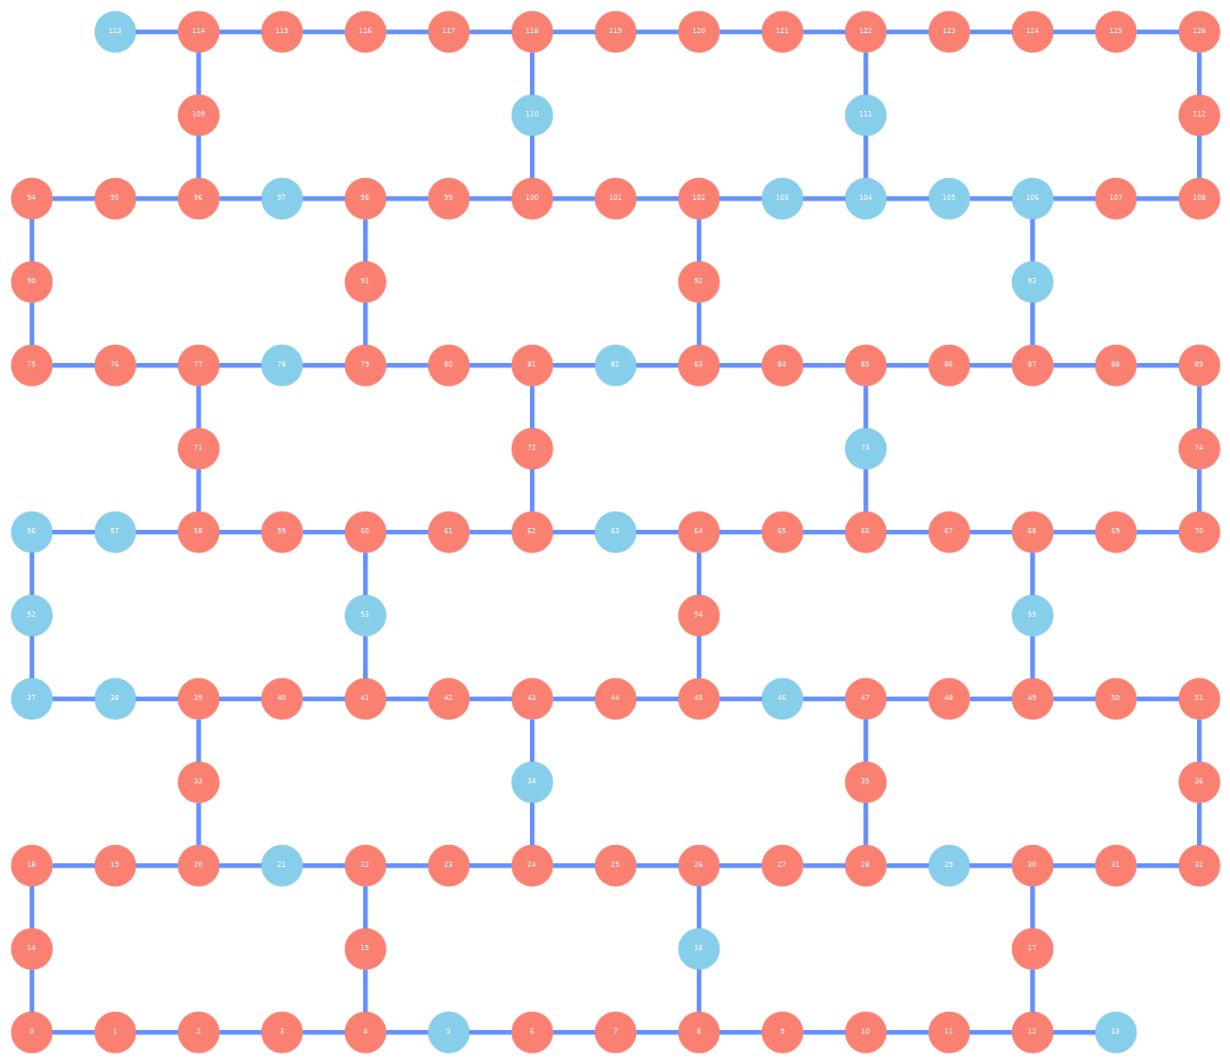

In [160]:
# Plot the best 100Q chain for a machine
machine = 'ibm_osaka'
print(f'100Q chain for {machine}')
qcolors = ['salmon' if i in qchains[machine] else 'skyblue' for i in range(0, backends[machine].configuration().n_qubits)]
plot_gate_map(backends[machine], label_qubits=True, qubit_color=qcolors)

# Plot distribution of 2Q errors for each backend

In [210]:
# Get 2q errors for each backend
tqerrors = {}
for machine in backend_names:
    # Get 2q gate
    backend = backends[machine]
    if "ecr" in backend.configuration().basis_gates:
        twoq_gate = "ecr"
    elif "cz" in backend.configuration().basis_gates:
        twoq_gate = "cz"
    else:
        twoq_gate = 'cx'

    # Extract 2q gate errors
    errors = []
    reset = []
    for gate in backend.properties().gates:
        gate_dict = gate.to_dict()
        if twoq_gate in gate_dict['gate']:
            error = gate_dict['parameters'][0]['value']
            errors.append(error)
    tqerrors[machine] = errors

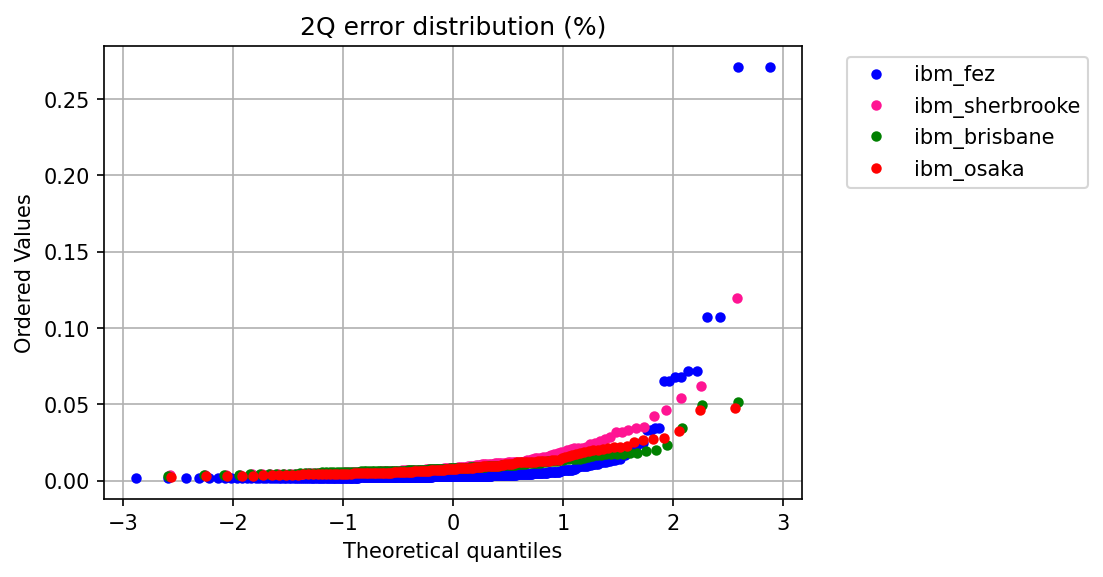

In [207]:
# Plot the distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
legend = []
for i, machine in enumerate(backend_names):
    errors = [x for x in tqerrors[machine] if 0<x<1] # clip values outside of normal range
    stats.probplot(errors, plot=plt, fit=False)
    ax.get_lines()[i].set_color(colors[i%len(colors)])
    plt.setp(ax.get_lines()[i], markersize=4)  #
    legend.append(machine)
ax.legend(legend, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('2Q error distribution (%)')
ax.figure.set_dpi(150)
plt.grid()
plt.show()